In [1]:
#pip install datasets

In [2]:
#pip install ultralytics

In [1]:
from google.colab import drive
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import torch
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from datasets import load_dataset, Dataset, DatasetDict
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the folder paths for the dataset
dataset_dir = '/content/drive/MyDrive/Dataset_IC01/Gigi Tampak Atas '
folder_paths = {
    'Gigi Sehat': os.path.join(dataset_dir, 'Gigi Sehat (Nodup)'),
    'Plak Gigi': os.path.join(dataset_dir, 'Plak Gigi'),
    'Gigi Berlubang': os.path.join(dataset_dir, 'Gigi Berlubang (Nodup)'),
    'Bengkak Gusi': os.path.join(dataset_dir, 'Bengkak Gusi'),
    'Bukan Gambar Gigi': os.path.join(dataset_dir, 'Bukan Gambar Gigi')
}

In [4]:
# Create main dataset directory
base_dataset_dir = '/content/dataset'
os.makedirs(base_dataset_dir, exist_ok=True)

# Create subdirectories for training, validation, and test sets
train_dir = os.path.join(base_dataset_dir, 'train')
val_dir = os.path.join(base_dataset_dir, 'val')
test_dir = os.path.join(base_dataset_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# Function to split data and copy images to train/val/test directories
def split_and_copy_images(folder_paths, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.1):
    from sklearn.model_selection import train_test_split
    import shutil

    for label, folder_path in folder_paths.items():
        image_files = os.listdir(folder_path)
        train_files, temp_files = train_test_split(image_files, test_size=(val_size + test_size), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_size/(val_size + test_size), random_state=42)

        # Create label directories in train, val, and test folders
        train_label_dir = os.path.join(train_dir, label)
        val_label_dir = os.path.join(val_dir, label)
        test_label_dir = os.path.join(test_dir, label)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)
        os.makedirs(test_label_dir, exist_ok=True)

        # Copy train images
        for image_file in train_files:
            shutil.copy2(os.path.join(folder_path, image_file), os.path.join(train_label_dir, image_file))

        # Copy val images
        for image_file in val_files:
            shutil.copy2(os.path.join(folder_path, image_file), os.path.join(val_label_dir, image_file))

        # Copy test images
        for image_file in test_files:
            shutil.copy2(os.path.join(folder_path, image_file), os.path.join(test_label_dir, image_file))

# Split data and create dataset
split_and_copy_images(folder_paths, train_dir, val_dir, test_dir)

print("Dataset split into training, validation, and test sets successfully!")

Dataset split into training, validation, and test sets successfully!


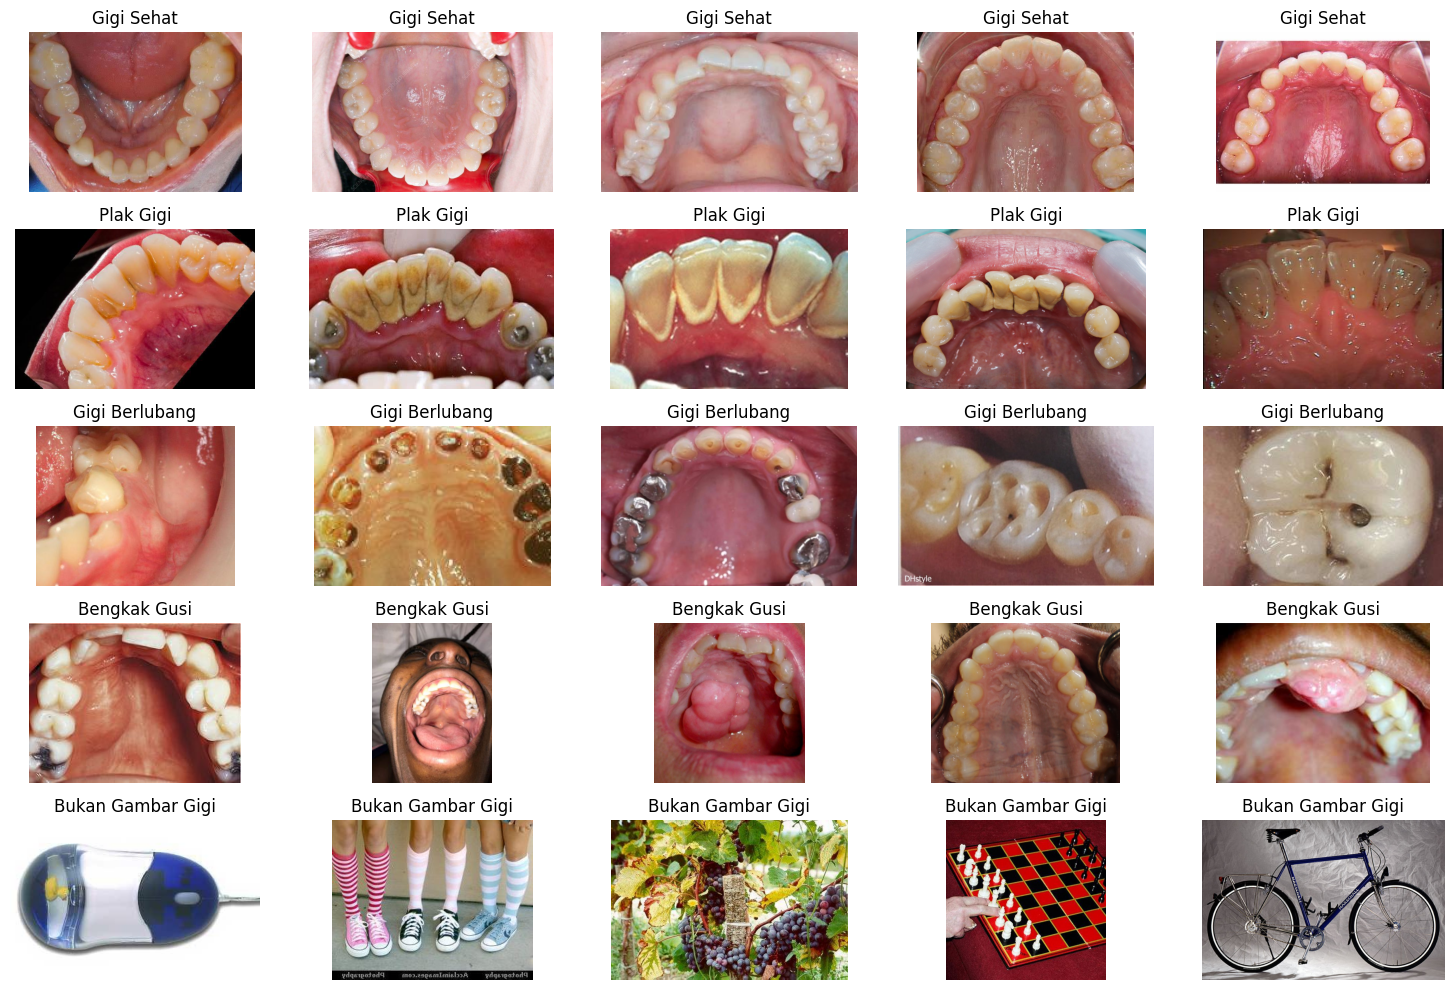

In [ ]:
# Function to display sample images with labels
def display_sample_images(dataset_dir, num_samples=5):
    fig, axes = plt.subplots(len(folder_paths), num_samples, figsize=(15, 10))
    for i, (label, folder_path) in enumerate(folder_paths.items()):
        image_files = os.listdir(os.path.join(dataset_dir, label))
        sampled_images = image_files[:num_samples]
        for j, image_file in enumerate(sampled_images):
            image_path = os.path.join(dataset_dir, label, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images with labels
display_sample_images(dataset_dir)

In [11]:
# import YOLO model
from ultralytics import YOLO

# Define YOLO model and train
model = YOLO('yolov8n-cls.pt')  # Specify the model version as needed

# Train the model
results = model.train(data=base_dataset_dir, epochs=30, imgsz=640,device=0)

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/dataset/train... 1769 images, 0 corrupt: 100%|██████████| 1769/1769 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/val... 505 images, 0 corrupt: 100%|██████████| 505/505 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

                   all       0.77          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

                   all      0.885          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

                   all      0.895          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30      1.41G     0.1554          9        640: 100%|██████████| 111/111 [01:09<00:00,  1.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30      1.42G      0.142          9        640: 100%|██████████| 111/111 [01:13<00:00,  1.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30      1.41G     0.1207          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30      1.41G     0.1314          9        640: 100%|██████████| 111/111 [01:12<00:00,  1.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30      1.41G     0.1212          9        640: 100%|██████████| 111/111 [01:11<00:00,  1.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30      1.42G     0.1013          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30      1.41G       0.11          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30      1.41G    0.09226          9        640: 100%|██████████| 111/111 [01:11<00:00,  1.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30      1.41G     0.1001          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30      1.42G    0.07924          9        640: 100%|██████████| 111/111 [01:11<00:00,  1.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30      1.41G    0.08333          9        640: 100%|██████████| 111/111 [01:12<00:00,  1.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

                   all      0.962          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      21/30      1.41G    0.06362          9        640: 100%|██████████| 111/111 [01:13<00:00,  1.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30      1.41G    0.07596          9        640: 100%|██████████| 111/111 [01:11<00:00,  1.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30      1.42G     0.0622          9        640: 100%|██████████| 111/111 [01:09<00:00,  1.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      24/30      1.41G    0.06353          9        640: 100%|██████████| 111/111 [01:08<00:00,  1.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30      1.41G    0.05511          9        640: 100%|██████████| 111/111 [01:11<00:00,  1.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30      1.41G    0.05614          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30      1.42G    0.05081          9        640: 100%|██████████| 111/111 [01:07<00:00,  1.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30      1.41G    0.05766          9        640: 100%|██████████| 111/111 [01:09<00:00,  1.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30      1.41G    0.05782          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30      1.41G    0.05247          9        640: 100%|██████████| 111/111 [01:10<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

                   all      0.966          1



30 epochs completed in 0.710 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1441285 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 1769 images in 5 classes ✅ 
val: /content/dataset/val... found 505 images in 5 classes ✅ 
test: /content/dataset/test... found 255 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all       0.97          1
Speed: 0.7ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


In [17]:
# Plot training results
model.val()

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
train: /content/dataset/train... found 1769 images in 5 classes ✅ 
val: /content/dataset/val... found 505 images in 5 classes ✅ 
test: /content/dataset/test... found 255 images in 5 classes ✅ 


val: Scanning /content/dataset/val... 505 images, 0 corrupt: 100%|██████████| 505/505 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


                   all       0.97          1
Speed: 1.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train23


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cd583c2d870>
curves: []
curves_results: []
fitness: 0.9851485192775726
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9702970385551453, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9851485192775726}
save_dir: PosixPath('runs/classify/train23')
speed: {'preprocess': 1.1287169881386332, 'inference': 3.43062948472429, 'loss': 0.0016698742857073794, 'postprocess': 0.0015102990783087099}
task: 'classify'
top1: 0.9702970385551453
top5: 1.0

In [22]:
results = model("/content/lubang.jpeg")  # predict on an image


image 1/1 /content/lubang.jpeg: 640x640 Gigi Berlubang 0.99, Gigi Sehat 0.01, Plak Gigi 0.00, Bengkak Gusi 0.00, Bukan Gambar Gigi 0.00, 6.7ms
Speed: 42.2ms preprocess, 6.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


In [24]:
path = model.export(format="onnx")  # export the model to ONNX format

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

PyTorch: starting from 'runs/classify/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5) (2.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 8.5s, saved as 'runs/classify/train2/weights/best.onnx' (5.5 MB)

Export complete (8.5s)
Results saved to /content/runs/classify/train2/weights
Predict:         yolo predict task=classify model=runs/classify/train2/weights/best.onnx imgsz=640  
Validate:        yolo val task=classify model=runs/classify/train2/weights/best.onnx imgsz=640 data=/content/dataset  
Visual

In [25]:
path

'runs/classify/train2/weights/best.onnx'